# Transfer Learning

In this session we will work with convolutional neural networks, when dealing with small datasets, which is a very usual situation, as data can be difficult to obtain in certain scenearios, specially labelled data.

Created by [Daniel Fojo](https://www.linkedin.com/in/daniel-fojo/) and [Xavier Giro-i-Nieto](https://imatge.upc.edu/web/people/xavier-giro) for the [Postgraduate course in artificial intelligence with deep learning](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/) in [UPC School](https://www.talent.upc.edu/ing/) (2019).

Based on previous versions by [Miriam Bellver](https://imatge.upc.edu/web/people/miriam-bellver) for the ([Barcelona Technology School](https://barcelonatechnologyschool.com/) 2018).

Updated by [Gerard I. Gállego](https://www.linkedin.com/in/gerard-gallego/).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

if not torch.cuda.is_available():
    raise Exception("You should enagle GPU in the Runtime menu")
device = torch.device("cuda")

## Downloading the database

During this  lab session, we will work with a small database of images with dogs and cats. The cats vs. dogs dataset that we will use isn't packaged with PyTorch. It was made available by Kaggle.com as part of a computer vision competition in late 2013, back when convnets weren't quite mainstream.

The following command line will download to your remote machine the Kaggle database that we will need for this lab session. It will take a few seconds.

In [ ]:
!wget --no-check-certificate "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip" -P /content/

--2023-11-16 13:10:29--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c03::cf, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   150MB/s    in 0.4s    

2023-11-16 13:10:29 (150 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



Now you will need to unzip the dataset that you have just downloaded, with the following line:

In [ ]:
!unzip -qq /content/cats_and_dogs_filtered.zip && rm /content/cats_and_dogs_filtered.zip
!mv /content/cats_and_dogs_filtered/* /datalab/

Now you already have the raw images at your remote machine.

## Training a convnet from scratch on a small dataset

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in
practice if you ever do computer vision in a professional context.

Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images. As a practical example, we will focus on
classifying images as "dogs" or "cats", in a dataset containing only 800 pictures of cats and dogs (400 cats, 400 dogs). We will use 400
pictures for training and 400 for validation.

In this section, we will review one basic strategy to tackle this problem: training a new model from scratch on what little data we have. We
will start by naively training a small convnet on our 400 training samples, without any regularization, to set a baseline for what can be
achieved. At that point, our main issue will be overfitting. Then we will introduce
*data augmentation*, a powerful technique for mitigating overfitting in computer vision. By leveraging data augmentation, we will improve
our network.

In the last section of today's session, we will review two more essential techniques for applying deep learning to small datasets: *doing feature extraction
with a pre-trained network* and *fine-tuning a pre-trained network*. Together, these three strategies -- training a small model from scratch, doing feature extracting using a
pre-trained model, and fine-tuning a pre-trained model -- will constitute your future toolbox for tackling the problem of doing computer
vision with small datasets.

### The relevance of deep learning for small-data problems

You will sometimes hear that deep learning only works when lots of data is available. This is in part a valid point: one fundamental
characteristic of deep learning is that it is able to find interesting features in the training data on its own, without any need for manual
feature engineering, and this can only be achieved when lots of training examples are available. This is especially true for problems where
the input samples are very high-dimensional, like images.

However, what constitutes "lots" of samples is relative -- relative to the size and depth of the network you are trying to train, for
starters. It isn't possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundreds can
potentially suffice if the model is small and well-regularized and if the task is simple.
Because convnets learn local, translation-invariant features, they are very
data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results
despite a relative lack of data, without the need for any custom feature engineering. You will see this in action in this section.

But what's more, deep learning models are by nature highly repurposable: you can take, say, an image classification or speech-to-text model
trained on a large-scale dataset then reuse it on a significantly different problem with only minor changes. Specifically, in the case of
computer vision, many pre-trained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used
to bootstrap powerful vision models out of very little data. That's what we will do in the next section.

For now, let's get started by getting our hands on the data.

## Preparing the data

Some sample images of the cats vs. dogs dataset look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used convnets. The best entries could achieve up to
95% accuracy. In our own example, we will get fairly close to this accuracy (in the next section), even though we will be training our
models on less than 5% of the data that was available to the competitors.
This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). After downloading
and uncompressing it, we will create a new dataset containing three subsets: a training set with 200 samples of each class and a validation
set with 200 samples of each class.

Here are a few lines of code to do this:

In [ ]:
import os, shutil

In [ ]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '/datalab/train/'

# The directory where we will
# store our smaller dataset
base_dir = '/content/processed_datalab'
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)

# Copy first 200 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(200)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, "cats", fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 200 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(200, 400)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, "cats", fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy first 200 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(200)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, "dogs", fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 200 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(200, 400)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, "dogs", fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 200
total training dog images: 200
total validation cat images: 200
total validation dog images: 200



So we have indeed 400 training images and 400 validation images. In each split, there is the same number of samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate measure of performance.

## Building our network
### Exercise 0

We've already built a small convnet for MNIST in a previous lab session, so you should be familiar with them. We will reuse the same  general structure: our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPool2D` layers.

However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have four `Conv2D` + `MaxPool2D` stages. This serves both to augment the capacity of the network, and to further reduce the size of the  feature maps, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 150x150 (a  somewhat arbitrary choice), and we want to end up with feature maps of size 7x7 right before the `Flatten` layer.

**Exercise 0:** Write the definition of the model using 2D convolutional layers with spatial kernel size 3x3 and (64, 128, 256, 256) output channels per each of the four layers, respectively. Include a a ReLu and a 2x2 max pooling operation after each convolutional operation.  At the end, add 2 fully-connected layers with 512 hidden units before the final binary classification with a `Sigmoid` activation between cats and dogs.



In [ ]:
# TODO
model = nn.Sequential(
    # Convolutional layers
    nn.Conv2d(3, 64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 256, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(256, 256, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # Flatten
    nn.Flatten(),

    # Fully connected layers
    nn.Linear(256 * 7 * 7, 512),
    nn.ReLU(),
    nn.Linear(512, 1),  # Output layer for binary classification with one unit
    nn.Sigmoid()
)

model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=12544, out_features=512, bias=True)
  (14): ReLU()
  (15): Linear(in_features=512, out_features=1, bias=True)
  (16): Sigmoid()
)

For the optimizer, we will use Adam. Since we are dealing with binary classification, we will use binary cross entropy as our loss function.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

## Data preprocessing

Data should be formatted into appropriately pre-processed floating point tensors before being fed into our
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Resize and crop the pictures to the desired size (150x150)
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully PyTorch has utilities included in the TorchVision library to take care of these steps automatically. We will use the `ImageFolder` Dataset class, which reads images from different folders, where each folder represents a different category. We will use `torchvision.transforms` to preprocess our data.

In [ ]:
transform = transforms.Compose([
                                transforms.Resize(150), # Resize the short side of the image to 150 keeping aspect ratio
                                transforms.CenterCrop(150), # Crop a square in the center of the image
                                transforms.ToTensor(), # Convert the image to a tensor with pixels in the range [0, 1]
                                ])
batch_size = 64

train_dataset = ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = ImageFolder(validation_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(64, 3, 150, 150)`) and binary
labels (shape `(64,)`). 64 is the number of samples in each batch (the batch size).

In [ ]:
for data_batch, labels_batch in train_loader:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: torch.Size([64, 3, 150, 150])
labels batch shape: torch.Size([64])


Let's fit our model to the data using the DataLoader.

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs):

    train_accuracies, train_losses, val_accuracies, val_losses = [], [], [], []
    val_loss = AverageMeter()
    val_accuracy = AverageMeter()
    train_loss = AverageMeter()
    train_accuracy = AverageMeter()

    for epoch in range(epochs):
        # train
        model.train()
        train_loss.reset()
        train_accuracy.reset()
        train_loop = tqdm(train_loader, unit=" batches")  # For printing the progress bar
        for data, target in train_loop:
            train_loop.set_description('[TRAIN] Epoch {}/{}'.format(epoch + 1, epochs))
            data, target = data.float().to(device), target.float().to(device)
            target = target.unsqueeze(-1)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss.update(loss.item(), n=len(target))
            pred = output.round()  # get the prediction
            acc = pred.eq(target.view_as(pred)).sum().item()/len(target)
            train_accuracy.update(acc, n=len(target))
            train_loop.set_postfix(loss=train_loss.avg, accuracy=train_accuracy.avg)

        train_losses.append(train_loss.avg)
        train_accuracies.append(train_accuracy.avg)

        # validation
        model.eval()
        val_loss.reset()
        val_accuracy.reset()
        val_loop = tqdm(val_loader, unit=" batches")  # For printing the progress bar
        with torch.no_grad():
            for data, target in val_loop:
                val_loop.set_description('[VAL] Epoch {}/{}'.format(epoch + 1, epochs))
                data, target = data.float().to(device), target.float().to(device)
                target = target.unsqueeze(-1)
                output = model(data)
                loss = loss_fn(output, target)
                val_loss.update(loss.item(), n=len(target))
                pred = output.round()  # get the prediction
                acc = pred.eq(target.view_as(pred)).sum().item()/len(target)
                val_accuracy.update(acc, n=len(target))
                val_loop.set_postfix(loss=val_loss.avg, accuracy=val_accuracy.avg)

        val_losses.append(val_loss.avg)
        val_accuracies.append(val_accuracy.avg)

    return train_accuracies, train_losses, val_accuracies, val_losses


In [ ]:
epochs = 60
train_accuracies, train_losses, val_accuracies, val_losses = train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs)

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

Let's plot the loss and accuracy of the model over the training and validation data during training:

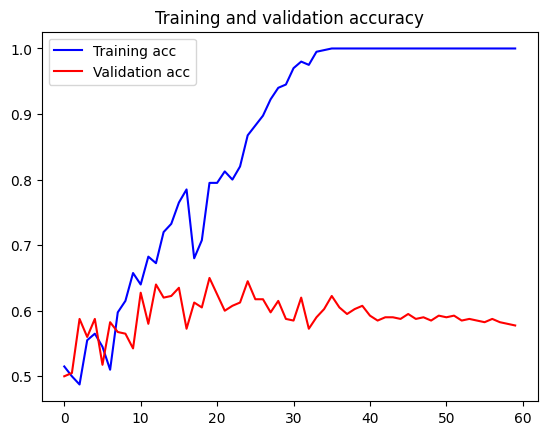

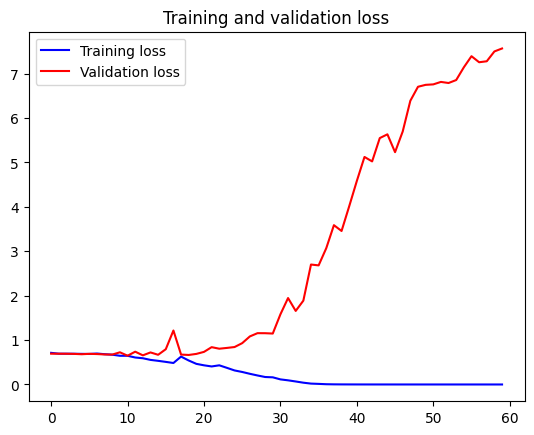

In [ ]:
epochs = range(len(train_accuracies))

plt.plot(epochs, train_accuracies, 'b', label='Training acc')
plt.plot(epochs, val_accuracies, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our
validation accuracy stalls at about 60%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss
keeps decreasing linearly until it reaches nearly 0.

Because we only have very few training samples (400), overfitting is going to be our number one concern. You already know about a
number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to
introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data
augmentation*.

## 1.  Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data.
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data
augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number
of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same
picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In PyTorch, this can be done by passaing TorchVision transformations to the Dataset. Let's get started with an example:

In [ ]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomRotation(10), transforms.RandomResizedCrop(150), transforms.ToTensor()])
val_transform = transforms.Compose([transforms.Resize(150), transforms.CenterCrop(150), transforms.ToTensor()])

batch_size = 64
augmented_dataset = ImageFolder(train_dir, transform=train_transform)
augmented_loader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)
val_dataset = ImageFolder(validation_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

These are just a few of the options available (for more, see in the [documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)). Let's quickly go over what we just wrote:

* `RandomRotation` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `RandomHorizontalFlip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal
asymmetry (e.g. real-world pictures).
* `RandomResizedCrop` randomly resize the image and returns a random crop with a small aspect ratio distorsion. Very popular transformation for training imagenet.

Let's take a look at our augmented images:

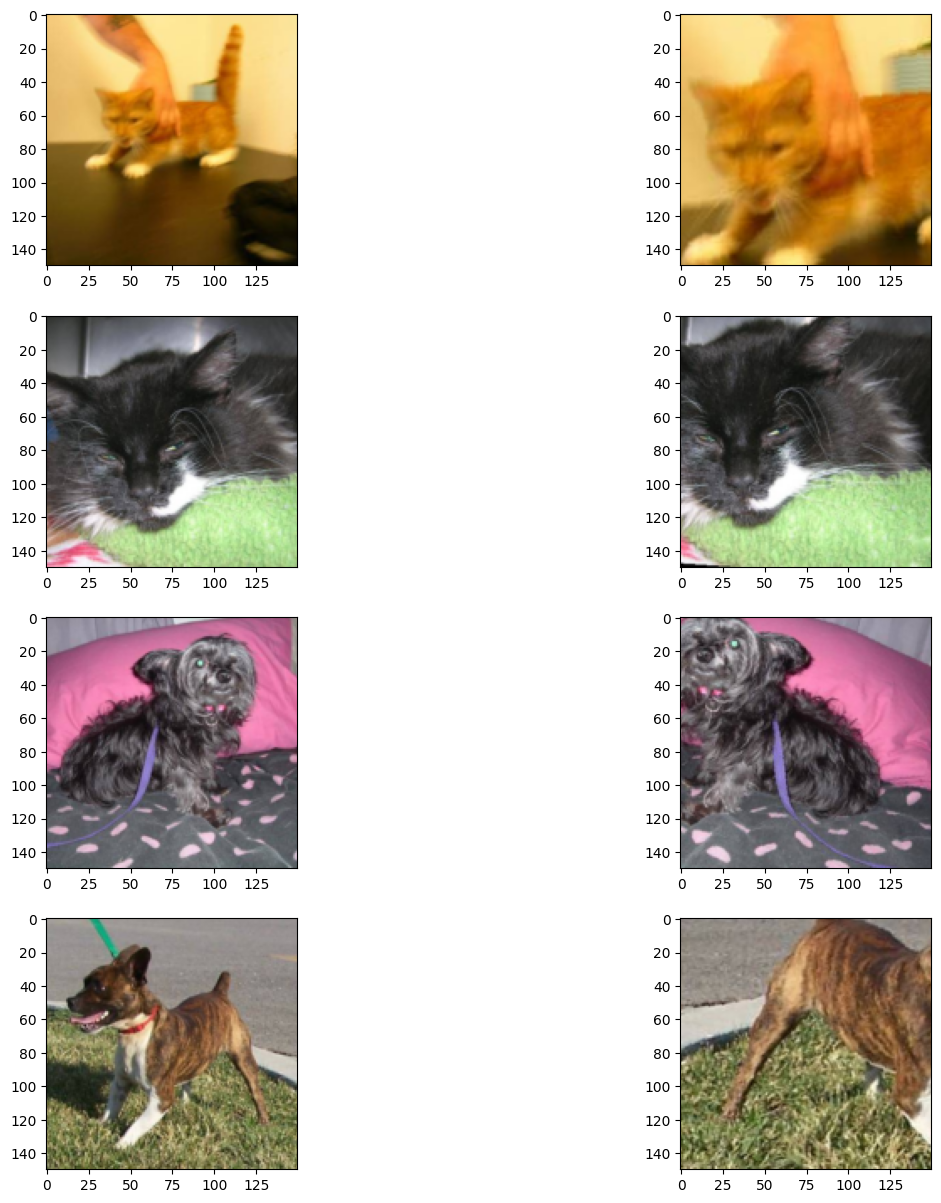

In [ ]:
random_indices = [0, 42, 200, 242]
augmented_images = [augmented_dataset[i][0] for i in random_indices]
augmented_images = [np.asarray(transforms.functional.to_pil_image(im)) for im in augmented_images]

images = [train_dataset[i][0] for i in random_indices]
images = [np.asarray(transforms.functional.to_pil_image(im)) for im in images]

fig, axes = plt.subplots(len(random_indices), 2, figsize=(15, 15))
for i in range(len(random_indices)):
    axes[i, 0].imshow(images[i])
    axes[i, 1].imshow(augmented_images[i])

### Dropout regularization

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information,
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting.


**Exercise 1:** To further fight  overfitting, add a [Dropout](https://pytorch.org/docs/stable/nn.html?highlight=dropout#torch.nn.Dropout) layer with probability 0.5 between the convolutional and fully connected layers.

In [ ]:
# TODO
model = nn.Sequential(
    # Convolutional layers
    nn.Conv2d(3, 64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 256, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(256, 256, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # Flatten
    nn.Flatten(),
    nn.Dropout(0.5),

    # Fully connected layers
    nn.Linear(256 * 7 * 7, 512),
    nn.ReLU(),
    nn.Linear(512, 1),  # Output layer for binary classification with one unit
    nn.Sigmoid()
)

model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=12544, out_features=512, bias=True)
  (15): ReLU()
  (16): Linear(in_features=512, out_features=1, bias=True)
  (17): Sigmoid()
)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

Let's train our network using data augmentation and dropout:

In [ ]:
epochs = 60
train_accuracies, train_losses, val_accuracies, val_losses = train_model(model, optimizer, loss_fn, augmented_loader, val_loader, epochs)


  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

  0%|          | 0/7 [00:00<?, ? batches/s]

Let's save a checkpoint of our model for future references.

In [ ]:
torch.save(model.state_dict(), 'cats_and_dogs_small_2_class.pt')
np.savez('history_cats_and_dogs_small_2_class.npz', train_accuracies=train_accuracies, train_losses=train_losses, val_accuracies=val_accuracies, val_losses=val_losses)

Plot the curves with the following lines:

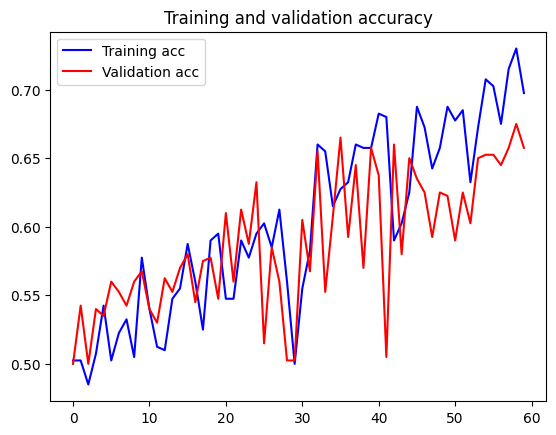

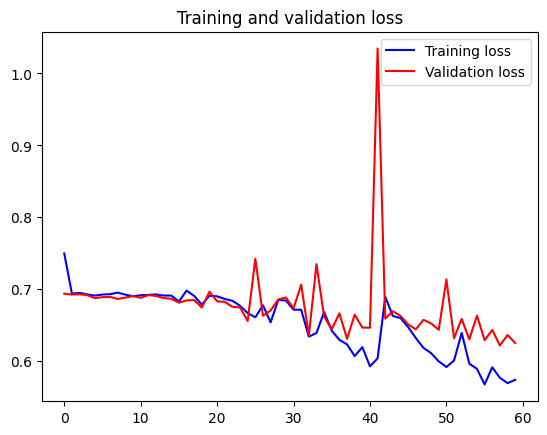

In [ ]:
epochs = range(len(train_accuracies))

plt.plot(epochs, train_accuracies, 'b', label='Training acc')
plt.plot(epochs, val_accuracies, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation
curves. We are now able to reach an accuracy of about 66%.

By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution
layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 70%. However, it would prove
very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. As a
next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next two
sections.

# 2 Using a pre-trained convnet

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task. For instance, one might train a network on ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes). ImageNet contains many animal classes, including different species of cats and dogs, and we can thus expect to perform very well on our cat vs. dog classification problem.

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture for ImageNet. Although it is a bit of an older model, far from the current state of the art and somewhat heavier than many other recent models, we chose it because its architecture is similar to what you are already familiar with, and easy to understand without introducing any new concepts.

There are two ways to leverage a pre-trained network: feature extraction and fine-tuning. We will cover both of them. Let's start with feature extraction. Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

As we saw previously, convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output.


![settings](https://camo.githubusercontent.com/2de162f6f3587a0422389355909594413ae17742/68747470733a2f2f73332e616d617a6f6e6177732e636f6d2f626f6f6b2e6b657261732e696f2f696d672f6368352f7377617070696e675f66635f636c61737369666965722e706e67)

Why only reuse the convolutional base? Could we reuse the densely-connected classifier as well? In general, it should be avoided. The reason is simply that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer vision problem at hand. On the other end, the representations learned by the classifier will necessarily be very specific to the set of classes that the model was trained on -- they will only contain information about the presence probability of this or that class in the entire picture. Additionally, representations found in densely-connected layers no longer contain any information about where objects are located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps. For problems where object location matters, densely-connected features would be largely useless.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). So if your new dataset differs a lot from the dataset that the original model was trained on, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

In our case, since the ImageNet class set did contain multiple dog and cat classes, it is likely that it would be beneficial to reuse the information contained in the densely-connected layers of the original model. However, we will chose not to, in order to cover the more general case where the class set of the new problem does not overlap with the class set of the original model.

Let's put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from our cat and dog images, and then training a cat vs. dog classifier on top of these features.

The VGG16 model, among others, comes pre-packaged with PyTorch. You can import it from the torchvision.models module.


In [ ]:
from torchvision.models import vgg16

pretrained_model = vgg16(pretrained=True)
pretrained_model.eval()
pretrained_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 78.2MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

The following line takes the first part of the model, to use it as a feature_extractor.

In [ ]:
feature_extractor = pretrained_model.features
feature_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si



The final feature map has shape (512, 4, 4). That's the feature on top of which we will stick a densely-connected classifier.

The method we will use consists in running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier. This solution is very fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at all.


We will start by simply running instances of the previously-introduced ImageFolder Dataset to extract features from these images.


In [ ]:
base_dir = '/content/processed_datalab'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')


def extract_features(directory):
    transform = transforms.Compose([transforms.Resize(150), transforms.CenterCrop(150), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  # Normalize with Imagenet parameters
    dataset = ImageFolder(directory, transform=transform)
    batch_size = 100
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    features = np.zeros(shape=(len(dataset), 512, 4, 4))
    labels = np.zeros(shape=(len(dataset),))
    with torch.no_grad():
        for i, (inputs_batch, labels_batch) in enumerate(loader):
            inputs_batch, labels_batch = inputs_batch.to(device), labels_batch.to(device)
            features_batch = feature_extractor(inputs_batch)
            features[i * batch_size : (i + 1) * batch_size] = features_batch.cpu().numpy()
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch.cpu().numpy()

    return features, labels

train_features, train_labels = extract_features(train_dir)
validation_features, validation_labels = extract_features(validation_dir)


The extracted features are currently of shape (samples, 512, 4, 4). We will feed them to a densely-connected classifier, so first we must flatten them to (samples, 8192):

In [ ]:
train_features = np.reshape(train_features, (-1, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (-1, 4 * 4 * 512))

### Exercise 2
At this point, we can define a neural network with a single hiden layer trained independetly with the visual features extracted from the VGG model.

**Exercise 2:** Implement this simple neural network with a 256 hidden neurons with a ReLU activation, and a dropout factor of 0.5 for both sets of parameters (input > hidden, hidden > output).

In [ ]:
# TODO
feature_classifier = nn.Sequential(
    nn.ReLU(),
    nn.Linear(512, 1),
)

feature_classifier.to(device)

Sequential(
  (0): ReLU()
  (1): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
optimizer = optim.Adam(feature_classifier.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

In [ ]:
from torch.utils.data import TensorDataset

batch_size = 64
train_features_dataset = TensorDataset(torch.tensor(train_features), torch.tensor(train_labels))
train_features_loader = DataLoader(train_features_dataset, batch_size=batch_size, shuffle=True)

val_features_dataset = TensorDataset(torch.tensor(validation_features), torch.tensor(validation_labels))
val_features_loader = DataLoader(val_features_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
epochs = 10
train_accuracies, train_losses, val_accuracies, val_losses = train_model(feature_classifier, optimizer, loss_fn, train_features_loader, val_features_loader, epochs)


Training is very fast, since we only have to deal with two Dense layers -- an epoch takes less than one second even on CPU.

Let's take a look at the loss and accuracy curves during training:


In [ ]:
epochs = range(len(train_accuracies))

plt.plot(epochs, train_accuracies, 'b', label='Training acc')
plt.plot(epochs, val_accuracies, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



We reach a validation accuracy of about 96%, much better than what we could achieve in the previous section with our small model trained from scratch. However, our plots also indicate that we are overfitting almost from the start -- despite using dropout with a fairly large rate. This is because this technique does not leverage data augmentation, which is essential to preventing overfitting with small image datasets.



# 3. Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is fine-tuning. Fine-tuning consists in unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

![finetuning](https://camo.githubusercontent.com/28a6cb7048317aba34f39cb02f15520708189008/68747470733a2f2f73332e616d617a6f6e6177732e636f6d2f626f6f6b2e6b657261732e696f2f696d672f6368352f76676731365f66696e655f74756e696e672e706e67)

We have stated before that it was necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classified wasn't already trained, then the error signal propagating through the network during training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps for fine-tuning a network are as follow:


1.   Add your custom network on top of an already trained base network.
2.   Freeze the base network.
3.   Train the part you added.
4.   Unfreeze some layers in the base network.
5.   Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step.

As a reminder, this is what our convolutional base looks like:


In [ ]:
pretrained_model = vgg16(pretrained=True)
pretrained_model.to(device)
feature_extractor = pretrained_model.features
feature_extractor

In [ ]:
for layer in feature_extractor[:24]:  # Freeze layers 0 to 23
    for param in layer.parameters():
        param.requires_grad = False

for layer in feature_extractor[24:]:  # Train layers 24 to 30
    for param in layer.parameters():
        param.requires_grad = True

We will fine-tune the last 3 convolutional layers.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? We could. However, we need to consider that:

1.   Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. It is more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem. There would be fast-decreasing returns in fine-tuning lower layers.
2.   The more parameters we are training, the more we are at risk of overfitting. The convolutional base has 15M parameters, so it would be risky to attempt to train it on our small dataset.

Thus, in our situation, it is a good strategy to only fine-tune the top 2 to 3 layers in the convolutional base.

Let's set this up, starting from where we left off in the previous example:


**Exercise 3:** Create a model with the `feature_classifier` of top of the `feature_extrator`. Note that you will need to flatten the features.

In [ ]:
# TODO
model = ...

model.to(device)

Now we can start fine-tuning our network. We will do this with the Adam optimizer, using a lower learning rate. The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers that we are fine-tuning. Updates that are too large may harm these representations.

Now let's proceed with fine-tuning:


In this case, we can do data augmentation, with the same configuration we used in our previous example:

In [ ]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomRotation(10), transforms.RandomResizedCrop(150), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  # We have to add ImageNet normalization
val_transform = transforms.Compose([transforms.Resize(150), transforms.CenterCrop(150), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

batch_size = 64
augmented_dataset = ImageFolder(train_dir, transform=train_transform)
augmented_loader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)
val_dataset = ImageFolder(validation_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.BCELoss()

In [ ]:
epochs = 60
train_accuracies, train_losses, val_accuracies, val_losses = train_model(model, optimizer, loss_fn, augmented_loader, val_loader, epochs)


And finally plot the curves:

In [ ]:
epochs = range(len(train_accuracies))

plt.plot(epochs, train_accuracies, 'b', label='Training acc')
plt.plot(epochs, val_accuracies, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Here we get a validation accuracy of 98%. In the original Kaggle competition around this dataset, this would have been one of the top results. However, using modern deep learning techniques, we managed to reach this result using only a very small fraction of the training data available (only about 2% of the data). There is a huge difference between being able to train on 20,000 samples compared to 400 samples!

# Take-aways: using convnets with small datasets

Here's what you should take away from these exercises:


*   Convnets are the best type of machine learning models for computer vision tasks. It is possible to train one from scratch even on a very small dataset, with decent results.
*   On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when working with image data.
*    It is easy to reuse an existing convnet on a new dataset, via feature extraction. This is a very valuable technique for working with small image datasets.
*   As a complement to feature extraction, one may use fine-tuning, which adapts to a new problem some of the representations previously learned by an existing model. This pushes performance a bit further.

Now you have a solid set of tools for dealing with image classification problems, in particular with small datasets.